<font size=6><center> Machine Learning - Assignment 2 </center><br></font>
    <font size=5><center> Three Optimization Problems</center></font>

<font size="4"><center>Author: Mohamed Amine DASSOULI </center></font>

In [2]:
import time
import itertools
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt

<a id='2'></a>
# Configuration

In [2]:
PATH_CSV_DATA = "Data/Churn_Modelling.csv"

<a id='3'></a>
# Functions

In [9]:
def minimization_problem(best_fitness, curves):
    offset = np.max(curves)
    new_curves = [-x+offset for x in curves]
    new_fitness = -best_fitness+offset
    
    return (new_fitness, new_curves)

In [74]:
def run_random_opti_algo(problem_fit, max_iters, algo="RHC", 
                         init_temp=1e6, exp_const=0.05, min_temp=0.001, 
                         pop_size=200, mutation_prob=0.1, 
                         keep_pct=0.2,
                         minimization=False, random_state=10, max_attempts=100):
    """
    Returns dictionary history of best state, best fitness, history fitness and duration for an algorithm.
    Keys: RHB, SA, GA, MI.
    """
    np.random.seed(random_state)

    history = {}
    timer = time.time()

    
    if algo=="RHC":
        best_state, best_fitness, curves = mlrose.random_hill_climb(problem_fit, max_attempts=max_attempts, 
                                                                                max_iters=max_iters, curve=True,
                                                                                random_state=random_state)
        
    
    elif algo=="SA":
        best_state, best_fitness, curves = mlrose.simulated_annealing( problem_fit, 
                                                                       schedule=mlrose.ExpDecay(init_temp=init_temp, 
                                                                                                exp_const=exp_const,
                                                                                                min_temp=min_temp),
                                                                       max_attempts=max_attempts, max_iters=max_iters, 
                                                                       curve=True, random_state=random_state)

   
    elif algo=="GA":
        best_state, best_fitness, curves = mlrose.genetic_alg(problem_fit, pop_size=pop_size, 
                                                                       mutation_prob=mutation_prob, 
                                                                       max_iters=max_iters, max_attempts=max_attempts, 
                                                                       curve=True, random_state=random_state)
       

    
    elif algo=="MIMIC":
        best_state, best_fitness, curves = mlrose.mimic(problem_fit, pop_size=pop_size, keep_pct=keep_pct, 
                                                                 max_attempts=max_attempts, max_iters=max_iters, 
                                                                 curve=True, random_state=random_state)
    
    current_time = time.time()

    if minimization: 
        best_fitness, curves = minimization_problem(best_fitness, curves)
    history = [best_state, best_fitness, curves, current_time-timer]
    timer = current_time

    return history

In [64]:
def gridsearch_sa(create_problem, problem_params, init_temp_values, exp_const_values,
                  max_iters, minimization=False, figsize=(12,10), max_attempts=200):
    
    plt.figure(figsize=figsize)
    for init_temp in init_temp_values:
        for exp_const in exp_const_values:
            problem_fit = create_problem(**problem_params)
            history = run_random_opti_algo(problem_fit, max_iters=max_iters, max_attempts=max_attempts,
                                           init_temp=init_temp, exp_const=exp_const, min_temp=0.001, 
                                           minimization=minimization, algo="SA")
            
            curves = history[2]
            print(curves[-1])
            plt.plot(np.arange(len(curves)), curves, label=f'init_temp={init_temp}, exp_const={exp_const}')

    plt.legend()
    plt.title(f'Gridsearch Simulated Annealing')
    plt.show()

In [65]:
def gridsearch_ga(create_problem, problem_params, pop_size_values, mutation_prob_values,
                  max_iters, minimization=False, figsize=(12,10), max_attempts=50):
   
    plt.figure(figsize=figsize)
    for pop_size in pop_size_values:
        for mutation_prob in mutation_prob_values:
            problem_fit = create_problem(**problem_params)
            history = run_random_opti_algo(problem_fit, max_iters=max_iters, max_attempts=max_attempts,
                                           pop_size=pop_size, mutation_prob=mutation_prob,
                                           minimization=minimization, algo="GA")

            curves = history[2]
            print(curves[-1])
            plt.plot(np.arange(len(curves)), curves, label=f'pop_size={pop_size}, mutation_prob={mutation_prob}')

    plt.legend()
    plt.title(f'Gridsearch Genetic Algorithms')
    plt.show()
    

In [76]:
def gridsearch_mimic(create_problem, problem_params, pop_size_values, keep_pct_values,
                     max_iters, minimization=False, figsize=(12,10), max_attempts=50):

    plt.figure(figsize=figsize)
    for pop_size in pop_size_values:
        for keep_pct in keep_pct_values:
            problem_fit = create_problem(**problem_params)
            history = run_random_opti_algo(problem_fit, max_iters=max_iters, max_attempts=max_attempts,
                                           pop_size=pop_size, keep_pct=keep_pct,
                                           minimization=minimization, algo="MIMIC")
            
            curves = history[2]
            print(curves[-1])
            plt.plot(np.arange(len(curves)), curves, label=f'pop_size={pop_size}, keep_pct={keep_pct}')

    plt.legend()
    plt.title(f'Gridsearch MIMIC')
    plt.show()

In [128]:
def create_tsp_problem(max_dist=10, max_cities=100, use_distance=False, random_state=1):

    if not use_distance:
        np.random.seed(random_state)
        x_coord = np.random.randint(1, max_dist+1, max_cities)
        y_coord = np.random.randint(1, max_dist+1, max_cities)
        coord_array = np.vstack((x_coord, y_coord))

        # Create list of city coordinates
        coords_list = list(set([(coord_array[0,i], coord_array[1,i]) for i in range(coord_array.shape[1])]))
        nb_cities = len(coords_list)

        # Initialize fitness function object using coords_list
        fitness_coords = mlrose.TravellingSales(coords=coords_list)

        # Define optimization problem object
        problem = mlrose.TSPOpt(length=nb_cities, fitness_fn=fitness_coords, maximize=False)

    else:
        # Create list of distances between pairs of cities
        list_test = [x for x in list(itertools.product(range(max_cities), repeat=2))]
        dist_list = []  
        for coords in list_test:
            x, y = coords
            if x != y and (y, x) not in dist_list:
                dist_list.append((x, y, np.random.uniform(0.01, max_dist)))
        
        nb_cities = len(dist_list)

        # Initialize fitness function object using dist_list
        fitness_dists = mlrose.TravellingSales(distances = dist_list)

        # Define optimization problem object
        problem = mlrose.TSPOpt(length=nb_cities, fitness_fn=fitness_dists, maximize=False)

    return problem

In [137]:
def create_flipflop_problem(size=10):
    # Initialize fitness function
    fitness_flipflop = mlrose.FlipFlop()

    # Define optimization problem object
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness_flipflop, maximize=True, max_val=2)

    return problem

In [172]:
def create_queens_problem(size=10):
    # Initialize fitness function
    fitness_queens = mlrose.Queens()

    # Define optimization problem object
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness_queens, maximize=False, max_val=size)

    return problem

<a id='6'></a>
# First problem: Travelling Salesman Problem

1731.251359001368
1677.7539911834403
1677.7539911834403
1633.9996353085783
2036.6266926736457
1865.5286047841937
377.8684542574438
2307.2732529827313
2062.6817010453287


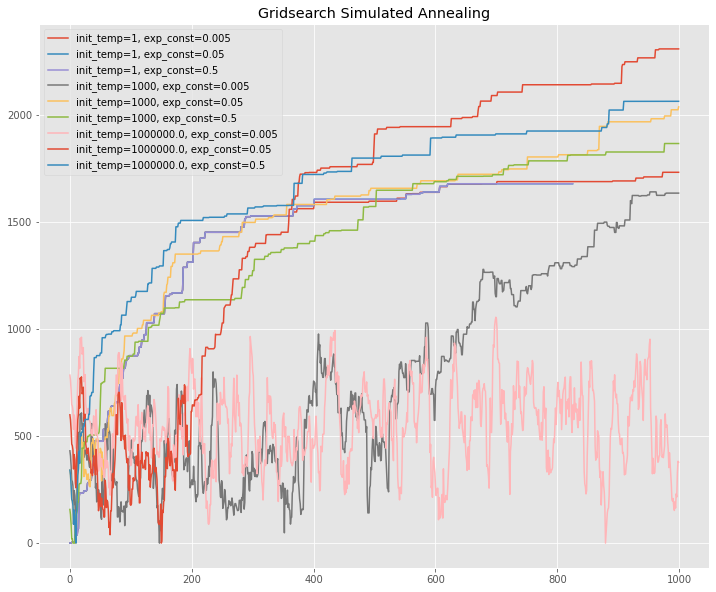

In [183]:
problem_params = {'max_dist': 120, 'max_cities': 50}
init_temp_values = [1, 1000, 1e6]
exp_const_values = [0.005, 0.05, 0.5]
gridsearch_sa(create_tsp_problem, problem_params, init_temp_values,
              exp_const_values, max_iters=1000, max_attempts=200,
              minimization=True)


1315.9907489565217
1471.2663800559758
1795.6429437901995
1523.457599607293
1250.980262704128
1402.1356163419953
1520.295815448094
1557.0254217704303
1107.7698249817004
1385.1037438924134
1532.0203657006837
1624.450447152813


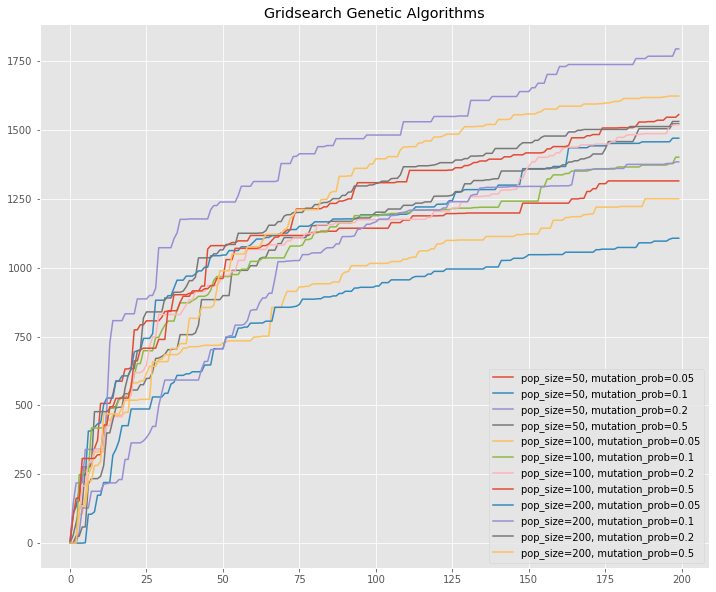

In [72]:
problem_params = {'max_dist': 120, 'max_cities': 50}
pop_size_values = [50, 100, 200]
mutation_prob_values = [0.05, 0.1, 0.2, 0.5]

gridsearch_ga(create_tsp_problem, problem_params, pop_size_values, mutation_prob_values,
                  max_iters=200, minimization=True, max_attempts=100)

0.0
0.0
371.4451276492
137.70977994430586
130.55051087868242
525.0971779020379
369.8862403727221
425.6854226685755
294.9420076802612
871.3347424760943
729.0671952473222
474.20218366419704


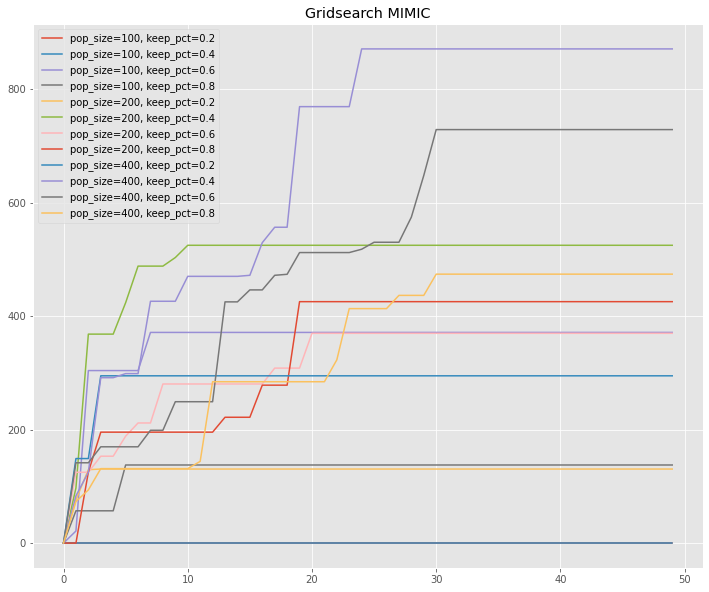

In [79]:
problem_params = {'max_dist': 120, 'max_cities': 50}
pop_size_values = [100, 200, 400]
keep_pct_values = [0.2, 0.4, 0.6, 0.8]

gridsearch_mimic(create_tsp_problem, problem_params, pop_size_values, keep_pct_values,
                  max_iters=50, minimization=True)

1643.0902805777464
1944.2132746690415
2076.3495845799816
1100.5244742367715


Text(0.5, 1.0, 'Optimization problems for Travelling Salesman Person')

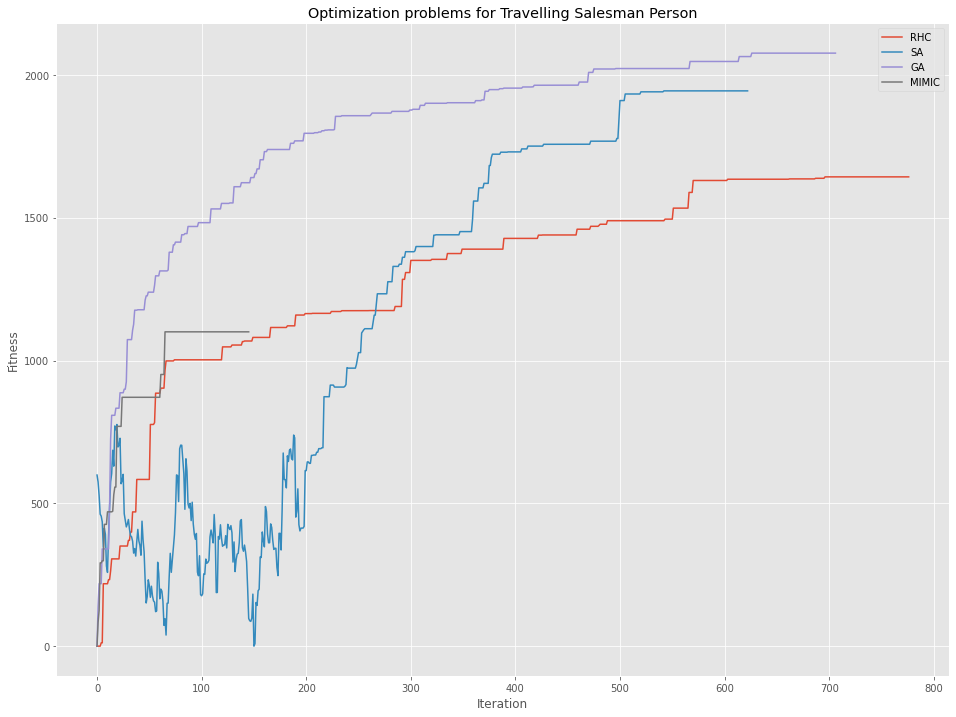

In [109]:
# Create TSP problem
problem_tsp = create_tsp_problem(max_dist=120, max_cities=50)

# Create figure
plt.figure(figsize=(16,12))

# Fitnesses
# RHC
RHC_hist = run_random_opti_algo(problem_tsp, max_iters=1000, minimization=True, algo="RHC", max_attempts=80)
RHC_curves = RHC_hist[2]
print(RHC_curves[-1])
plt.plot(np.arange(len(RHC_curves)), RHC_curves, 
        label='RHC')

# SA
SA_hist = run_random_opti_algo(problem_tsp, max_iters=1000, minimization=True, algo="SA",
                              init_temp=1e6, exp_const=0.05, max_attempts=80)
SA_curves = SA_hist[2]
print(SA_curves[-1])
plt.plot(np.arange(len(SA_curves)), SA_curves, 
        label='SA')

# GA
GA_hist = run_random_opti_algo(problem_tsp, max_iters=1000, minimization=True, algo="GA",
                               pop_size=50, mutation_prob=0.2, max_attempts=80)
GA_curves = GA_hist[2]
print(GA_curves[-1])
plt.plot(np.arange(len(GA_curves)), GA_curves, 
        label='GA')

# MIMIC
MIMIC_hist = run_random_opti_algo(problem_tsp, max_iters=1000, minimization=True, algo="MIMIC",
                                  pop_size=400, keep_pct=0.4, max_attempts=80)
MIMIC_curves = MIMIC_hist[2]
print(MIMIC_curves[-1])
plt.plot(np.arange(len(MIMIC_curves)), MIMIC_curves, 
        label='MIMIC')


plt.legend()
plt.ylabel("Fitness")
plt.xlabel("Iteration")
plt.title("Optimization problems for Travelling Salesman Person")


In [111]:
# Wall clock times
print("RHC:", round(RHC_hist[3], 2), "s")
print("SA:", round(SA_hist[3], 2), "s")
print("GA:", round(GA_hist[3], 2), "s")
print("MIMIC:", round(MIMIC_hist[3], 2), "s")

RHC: 0.13 s
SA: 0.11 s
GA: 10.53 s
MIMIC: 386.0 s


Changing problem size and evaluating algorithms:

In [133]:
max_cities_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
algos = ["RHC", "SA", "GA", "MIMIC"]
fitnesses = dict([(algo, []) for algo in algos])
clock_times = dict([(algo, []) for algo in algos])
iterations = dict([(algo, []) for algo in algos])

for max_cities in max_cities_values:
    # Create TSP problem
    problem_tsp = create_tsp_problem(max_dist=120, max_cities=max_cities)

    # RHC
    RHC_hist = run_random_opti_algo(problem_tsp, max_iters=500, minimization=True, algo="RHC", max_attempts=20)
    print("rhc")
    fitnesses["RHC"].append(RHC_hist[1])
    clock_times["RHC"].append(RHC_hist[3])
    iterations["RHC"].append(len(RHC_hist[2]))

    # SA
    SA_hist = run_random_opti_algo(problem_tsp, max_iters=500, minimization=True, algo="SA",
                                  init_temp=1e6, exp_const=0.05, max_attempts=20)
    print("sa")
    fitnesses["SA"].append(SA_hist[1])
    clock_times["SA"].append(SA_hist[3])
    iterations["SA"].append(len(SA_hist[2]))
    
    # GA
    GA_hist = run_random_opti_algo(problem_tsp, max_iters=500, minimization=True, algo="GA",
                                   pop_size=50, mutation_prob=0.2, max_attempts=30)
    print("ga")
    fitnesses["GA"].append(GA_hist[1])
    clock_times["GA"].append(GA_hist[3])
    iterations["GA"].append(len(GA_hist[2]))

    # MIMIC
    MIMIC_hist = run_random_opti_algo(problem_tsp, max_iters=500, minimization=True, algo="MIMIC",
                                      pop_size=400, keep_pct=0.4, max_attempts=20)
    print("mimic")
    fitnesses["MIMIC"].append(MIMIC_hist[1])
    clock_times["MIMIC"].append(MIMIC_hist[3])
    iterations["MIMIC"].append(len(MIMIC_hist[2]))

rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic
rhc
sa
ga
mimic


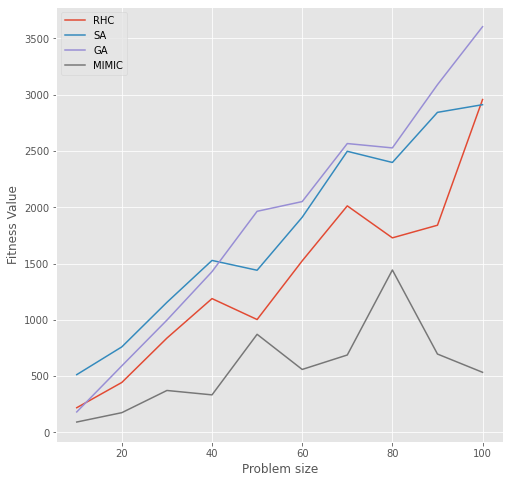

In [134]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(max_cities_values, fitnesses[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Fitness Value")
plt.legend()
plt.show()

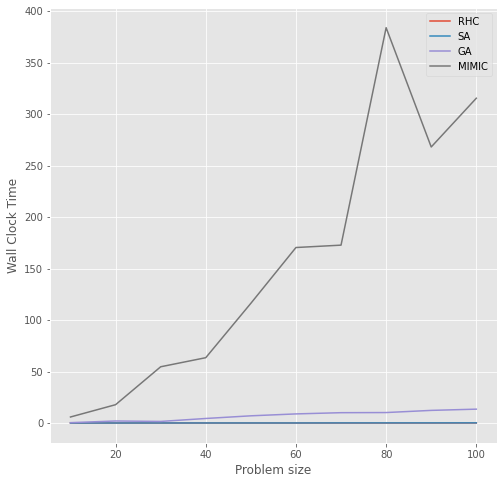

In [135]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(max_cities_values, clock_times[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Wall Clock Time")
plt.legend()
plt.show()

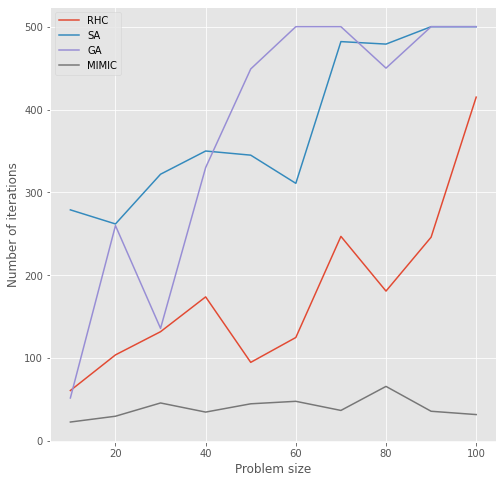

In [136]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(max_cities_values, iterations[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Number of iterations")
plt.legend()
plt.show()

<a id='6'></a>
# Second problem: Flip Flop

46.0
62.0
62.0
46.0
61.0
64.0
39.0
58.0
66.0
39.0
53.0
68.0


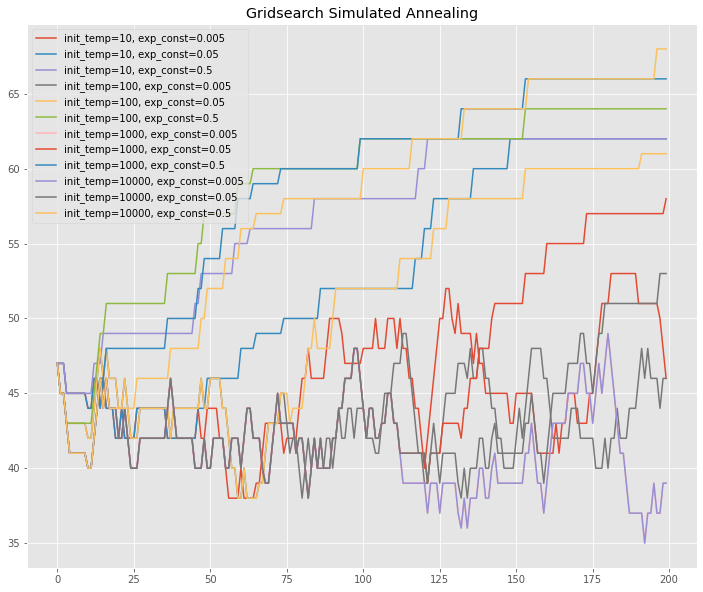

In [182]:
problem_params = {'size': 80}
init_temp_values = [10, 100, 1000, 10000]
exp_const_values = [0.005, 0.05, 0.5]
gridsearch_sa(create_flipflop_problem, problem_params, init_temp_values,
              exp_const_values, max_iters=200, max_attempts=2000,
              minimization=False)

75.0
72.0
70.0
70.0
72.0
73.0
69.0
71.0
69.0
73.0
70.0
67.0


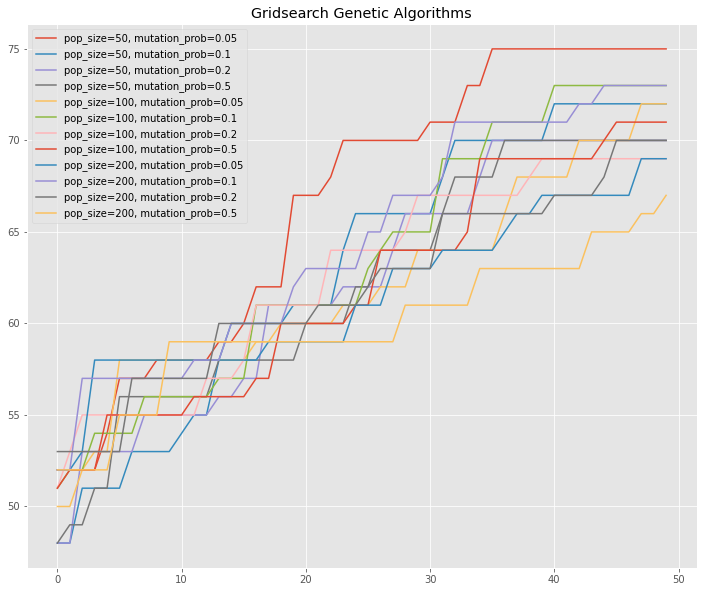

In [165]:
problem_params = {'size': 80}
pop_size_values = [50, 100, 200]
mutation_prob_values = [0.05, 0.1, 0.2, 0.5]
gridsearch_ga(create_flipflop_problem, problem_params, pop_size_values, mutation_prob_values,
                  max_iters=50, minimization=False, max_attempts=20)

68.0
67.0
61.0
55.0
72.0
72.0
74.0
56.0
75.0
77.0
76.0
66.0


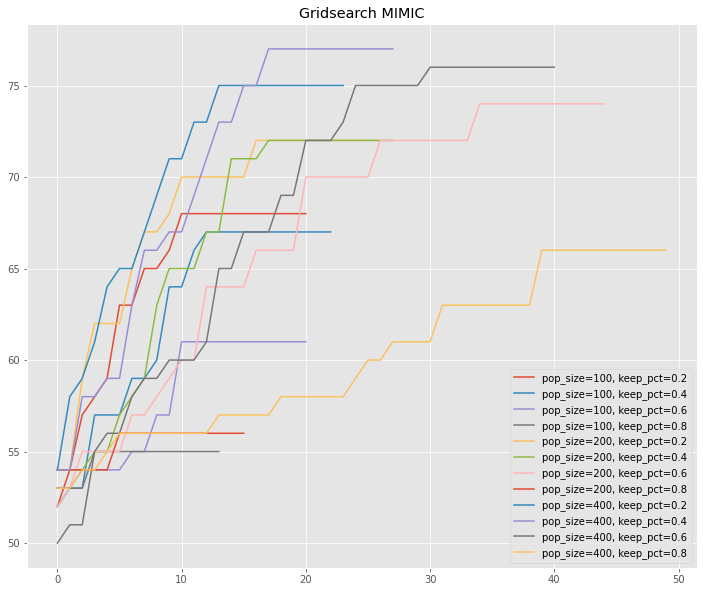

In [164]:
problem_params = {'size':80}
pop_size_values = [100, 200, 400]
keep_pct_values = [0.2, 0.4, 0.6, 0.8]

gridsearch_mimic(create_flipflop_problem, problem_params, pop_size_values, keep_pct_values,
                  max_iters=50, minimization=False, max_attempts=10)

52.0
61.0
75.0
77.0


Text(0.5, 1.0, 'Optimization problems for Flip Flop')

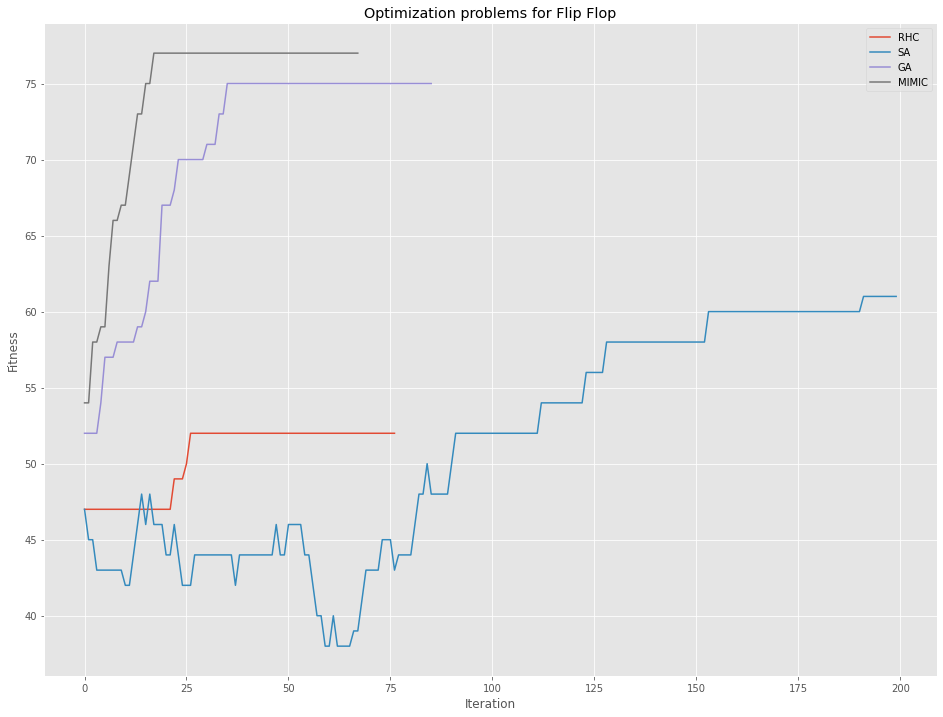

In [169]:
# Create FlipFlop problem
problem_flipflop = create_flipflop_problem(size=80)

# Create figure
plt.figure(figsize=(16,12))

# Fitnesses
# RHC
RHC_hist = run_random_opti_algo(problem_flipflop, max_iters=200, algo="RHC", max_attempts=50)
RHC_curves = RHC_hist[2]
print(RHC_curves[-1])
plt.plot(np.arange(len(RHC_curves)), RHC_curves, 
        label='RHC')

# SA
SA_hist = run_random_opti_algo(problem_flipflop, max_iters=200, algo="SA",
                              init_temp=100, exp_const=0.5, max_attempts=50)
SA_curves = SA_hist[2]
print(SA_curves[-1])
plt.plot(np.arange(len(SA_curves)), SA_curves, 
        label='SA')

# GA
GA_hist = run_random_opti_algo(problem_flipflop, max_iters=200, algo="GA",
                               pop_size=50, mutation_prob=0.05, max_attempts=50)
GA_curves = GA_hist[2]
print(GA_curves[-1])
plt.plot(np.arange(len(GA_curves)), GA_curves, 
        label='GA')

# MIMIC
MIMIC_hist = run_random_opti_algo(problem_flipflop, max_iters=200, algo="MIMIC",
                                  pop_size=400, keep_pct=0.4, max_attempts=50)
MIMIC_curves = MIMIC_hist[2]
print(MIMIC_curves[-1])
plt.plot(np.arange(len(MIMIC_curves)), MIMIC_curves, 
        label='MIMIC')


plt.legend()
plt.ylabel("Fitness")
plt.xlabel("Iteration")
plt.title("Optimization problems for Flip Flop")


In [170]:
# Wall clock times
print("RHC:", round(RHC_hist[3], 2), "s")
print("SA:", round(SA_hist[3], 2), "s")
print("GA:", round(GA_hist[3], 2), "s")
print("MIMIC:", round(MIMIC_hist[3], 2), "s")

RHC: 0.02 s
SA: 0.08 s
GA: 1.18 s
MIMIC: 243.48 s


Changing problem size and evaluating algorithms:

In [ ]:
size_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
algos = ["RHC", "SA", "GA", "MIMIC"]
fitnesses = dict([(algo, []) for algo in algos])
clock_times = dict([(algo, []) for algo in algos])
iterations = dict([(algo, []) for algo in algos])

for size in size_values:
    # Create Flip Flop problem
    problem_flipflop = create_flipflop_problem(size=size)

    # RHC
    RHC_hist = run_random_opti_algo(problem_flipflop, max_iters=500, algo="RHC", max_attempts=20)
    print("rhc", RHC_hist[1])
    fitnesses["RHC"].append(RHC_hist[1])
    clock_times["RHC"].append(RHC_hist[3])
    iterations["RHC"].append(len(RHC_hist[2]))

    # SA
    SA_hist = run_random_opti_algo(problem_flipflop, max_iters=500, algo="SA",
                                  init_temp=100, exp_const=0.005, max_attempts=20)
    print("sa", SA_hist[1])
    fitnesses["SA"].append(SA_hist[1])
    clock_times["SA"].append(SA_hist[3])
    iterations["SA"].append(len(SA_hist[2]))
    
    # GA
    GA_hist = run_random_opti_algo(problem_flipflop, max_iters=500, algo="GA",
                                   pop_size=50, mutation_prob=0.05, max_attempts=20)
    print("ga", GA_hist[1])
    fitnesses["GA"].append(GA_hist[1])
    clock_times["GA"].append(GA_hist[3])
    iterations["GA"].append(len(GA_hist[2]))

    # MIMIC
    MIMIC_hist = run_random_opti_algo(problem_flipflop, max_iters=500, algo="MIMIC",
                                      pop_size=400, keep_pct=0.4, max_attempts=20)
    print("mimic", MIMIC_hist[1])
    fitnesses["MIMIC"].append(MIMIC_hist[1])
    clock_times["MIMIC"].append(MIMIC_hist[3])
    iterations["MIMIC"].append(len(MIMIC_hist[2]))

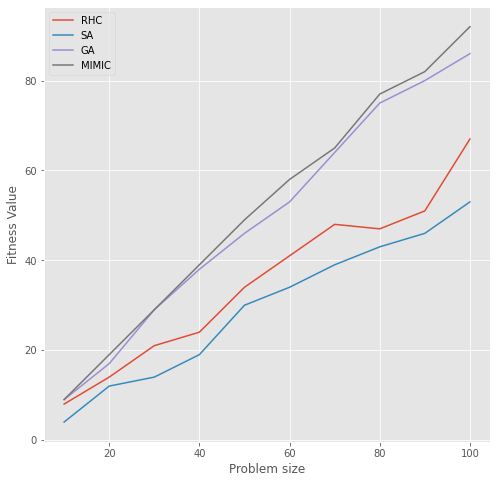

In [159]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, fitnesses[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Fitness Value")
plt.legend()
plt.show()

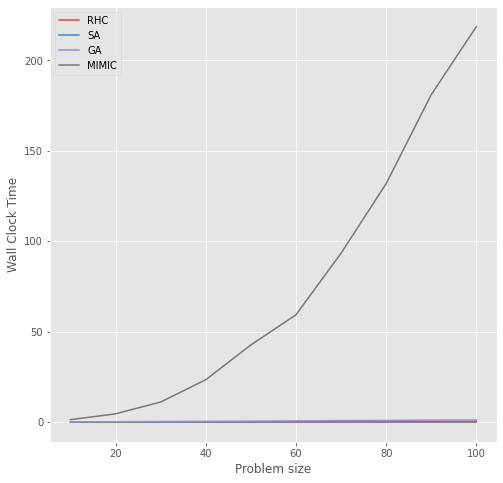

In [161]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, clock_times[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Wall Clock Time")
plt.legend()
plt.show()

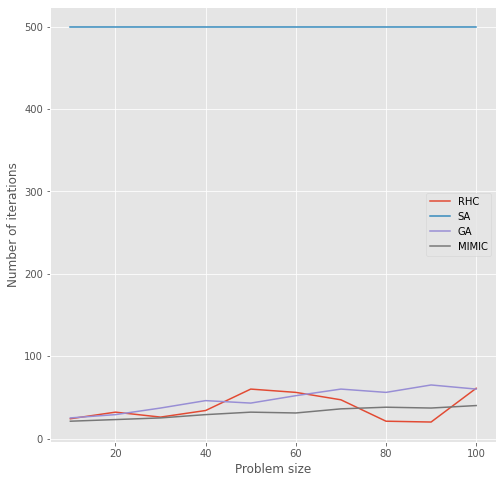

In [162]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, iterations[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Number of iterations")
plt.legend()
plt.show()

<a id='6'></a>
# Third problem: 

28.0
43.0
35.0
28.0
51.0
41.0
17.0
48.0
40.0
17.0
47.0
45.0


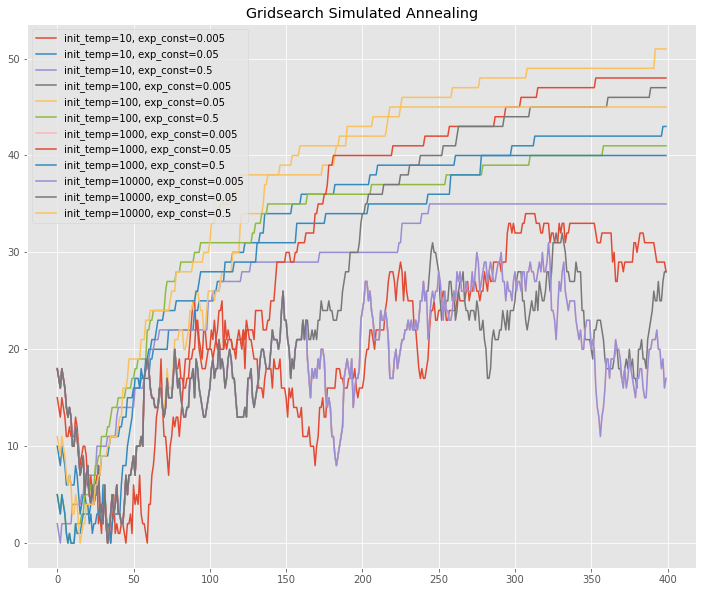

In [185]:
problem_params = {'size': 40}
init_temp_values = [10, 100, 1000, 10000]
exp_const_values = [0.005, 0.05, 0.5]
gridsearch_sa(create_queens_problem, problem_params, init_temp_values,
              exp_const_values, max_iters=400, max_attempts=2000,
              minimization=True)

16.0
19.0
16.0
18.0
18.0
17.0
18.0
21.0
20.0
20.0
21.0
8.0


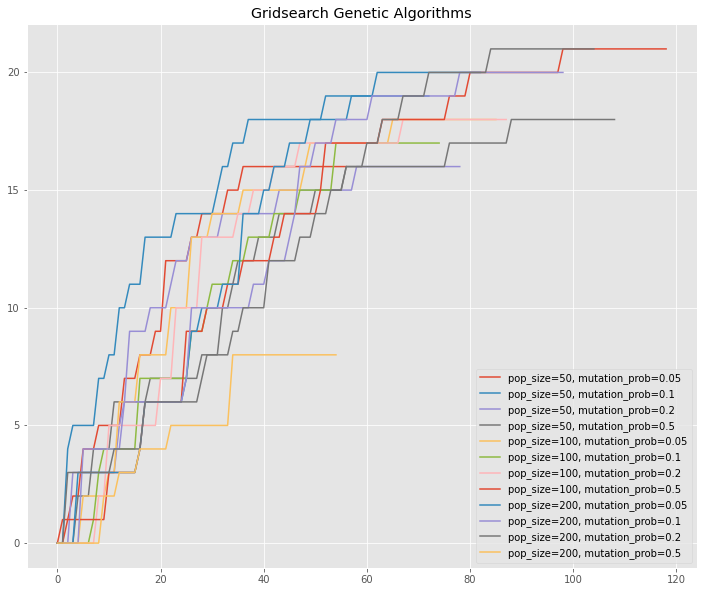

In [179]:
problem_params = {'size': 40}
pop_size_values = [50, 100, 200]
mutation_prob_values = [0.05, 0.1, 0.2, 0.5]
gridsearch_ga(create_queens_problem, problem_params, pop_size_values, mutation_prob_values,
                  max_iters=200, minimization=True, max_attempts=20)

3.0
1.0
4.0
1.0
5.0
10.0
5.0
5.0
11.0
11.0
10.0
7.0


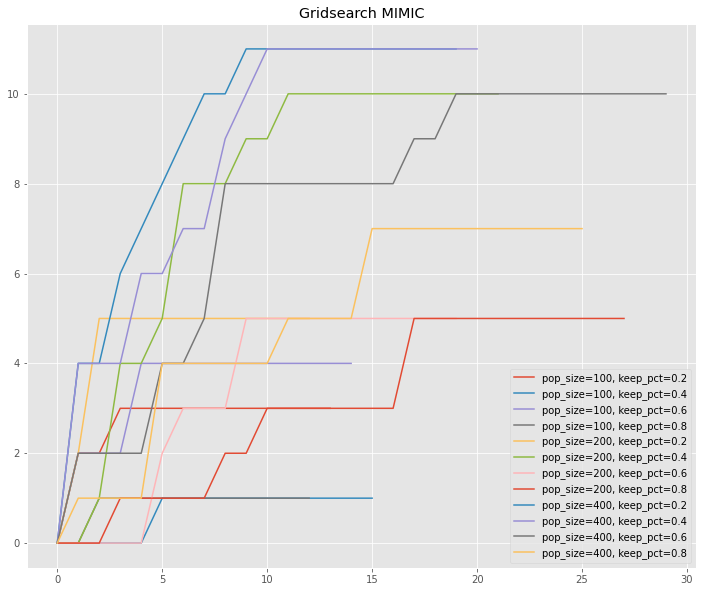

In [177]:
problem_params = {'size': 40}
pop_size_values = [100, 200, 400]
keep_pct_values = [0.2, 0.4, 0.6, 0.8]

gridsearch_mimic(create_queens_problem, problem_params, pop_size_values, keep_pct_values,
                  max_iters=50, minimization=True, max_attempts=10)

28.0
48.0
21.0
11.0


Text(0.5, 1.0, 'Optimization problems for Queens')

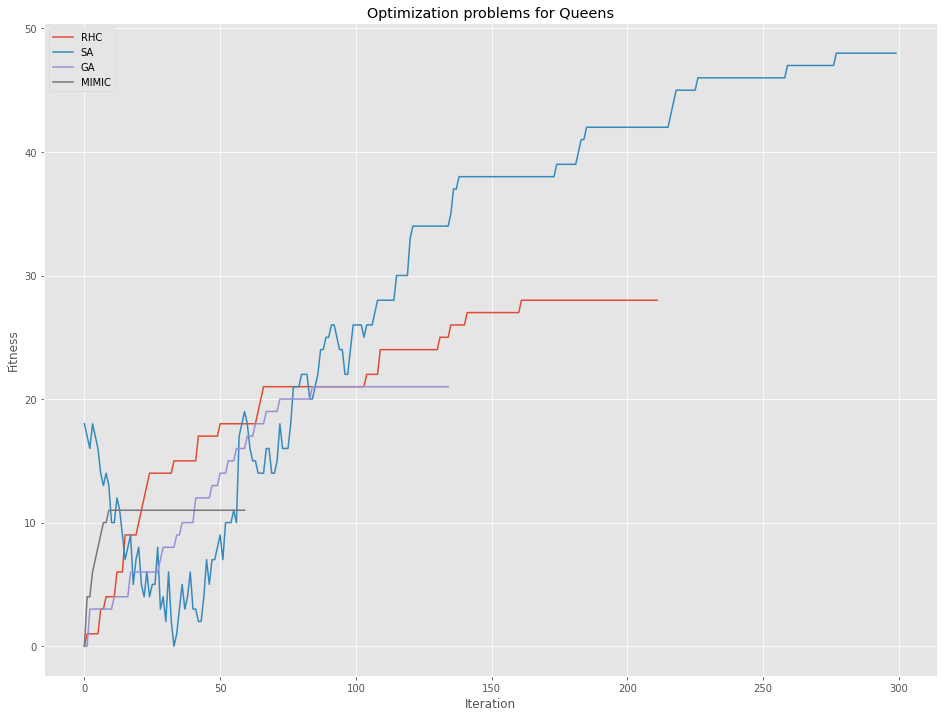

In [186]:
# Create Queens problem
problem_queens = create_queens_problem(size=40)

# Create figure
plt.figure(figsize=(16,12))

# Fitnesses
# RHC
RHC_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="RHC", max_attempts=50, minimization=True)
RHC_curves = RHC_hist[2]
print(RHC_curves[-1])
plt.plot(np.arange(len(RHC_curves)), RHC_curves, 
        label='RHC')

# SA
SA_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="SA",
                              init_temp=100, exp_const=0.05, max_attempts=50, minimization=True)
SA_curves = SA_hist[2]
print(SA_curves[-1])
plt.plot(np.arange(len(SA_curves)), SA_curves, 
        label='SA')

# GA
GA_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="GA",
                               pop_size=200, mutation_prob=0.2, max_attempts=50, minimization=True)
GA_curves = GA_hist[2]
print(GA_curves[-1])
plt.plot(np.arange(len(GA_curves)), GA_curves, 
        label='GA')

# MIMIC
MIMIC_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="MIMIC",
                                  pop_size=400, keep_pct=0.2, max_attempts=50, minimization=True)
MIMIC_curves = MIMIC_hist[2]
print(MIMIC_curves[-1])
plt.plot(np.arange(len(MIMIC_curves)), MIMIC_curves, 
        label='MIMIC')


plt.legend()
plt.ylabel("Fitness")
plt.xlabel("Iteration")
plt.title("Optimization problems for Queens")


In [187]:
# Wall clock times
print("RHC:", round(RHC_hist[3], 2), "s")
print("SA:", round(SA_hist[3], 2), "s")
print("GA:", round(GA_hist[3], 2), "s")
print("MIMIC:", round(MIMIC_hist[3], 2), "s")

RHC: 0.23 s
SA: 0.45 s
GA: 25.93 s
MIMIC: 82.29 s


In [189]:
size_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
algos = ["RHC", "SA", "GA", "MIMIC"]
fitnesses = dict([(algo, []) for algo in algos])
clock_times = dict([(algo, []) for algo in algos])
iterations = dict([(algo, []) for algo in algos])

for size in size_values:
    # Create Queens problem
    problem_queens = create_queens_problem(size=size)

    # RHC
    RHC_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="RHC", max_attempts=20, minimization=True)
    print("rhc", RHC_hist[1])
    fitnesses["RHC"].append(RHC_hist[1])
    clock_times["RHC"].append(RHC_hist[3])
    iterations["RHC"].append(len(RHC_hist[2]))

    # SA
    SA_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="SA", minimization=True,
                                  init_temp=100, exp_const=0.05, max_attempts=20)
    print("sa", SA_hist[1])
    fitnesses["SA"].append(SA_hist[1])
    clock_times["SA"].append(SA_hist[3])
    iterations["SA"].append(len(SA_hist[2]))
    
    # GA
    GA_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="GA", minimization=True,
                                   pop_size=200, mutation_prob=0.2, max_attempts=20)
    print("ga", GA_hist[1])
    fitnesses["GA"].append(GA_hist[1])
    clock_times["GA"].append(GA_hist[3])
    iterations["GA"].append(len(GA_hist[2]))

    # MIMIC
    MIMIC_hist = run_random_opti_algo(problem_queens, max_iters=300, algo="MIMIC", minimization=True,
                                      pop_size=400, keep_pct=0.2, max_attempts=20)
    print("mimic", MIMIC_hist[1])
    fitnesses["MIMIC"].append(MIMIC_hist[1])
    clock_times["MIMIC"].append(MIMIC_hist[3])
    iterations["MIMIC"].append(len(MIMIC_hist[2]))

rhc 7.0
sa 12.0
ga 3.0
mimic 4.0
rhc 8.0
sa 24.0
ga 9.0
mimic 4.0
rhc 18.0
sa 28.0
ga 13.0
mimic 9.0
rhc 21.0
sa 48.0
ga 21.0
mimic 11.0
rhc 36.0
sa 50.0
ga 29.0
mimic 8.0
rhc 24.0
sa 50.0
ga 36.0
mimic 9.0
rhc 37.0
sa 61.0
ga 13.0
mimic 16.0
rhc 45.0
sa 53.0
ga 49.0
mimic 13.0
rhc 26.0
sa 45.0
ga 56.0
mimic 10.0
rhc 30.0
sa 54.0
ga 65.0
mimic 24.0


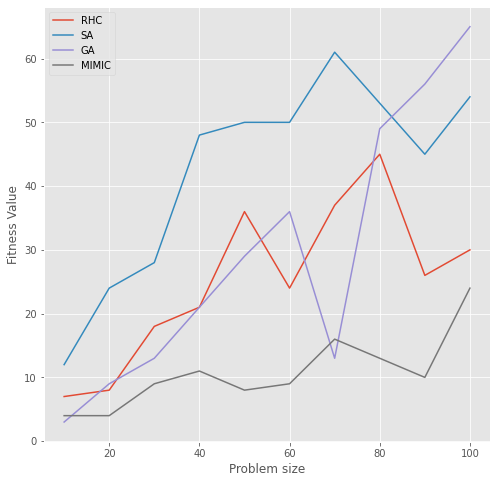

In [190]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, fitnesses[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Fitness Value")
plt.legend()
plt.show()

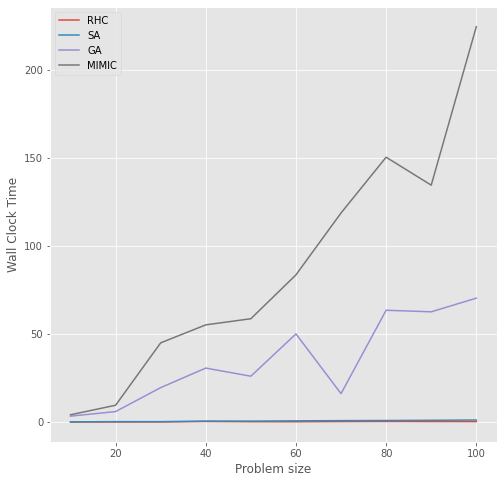

In [191]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, clock_times[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Wall Clock Time")
plt.legend()
plt.show()

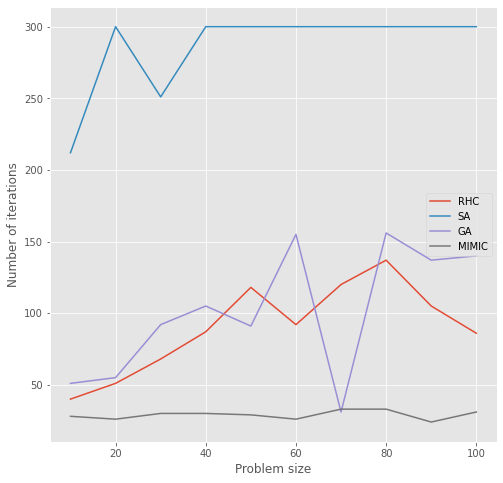

In [192]:
plt.figure(figsize=(8,8))

for algo in algos:
    plt.plot(size_values, iterations[algo], label=algo)
plt.xlabel("Problem size")
plt.ylabel("Number of iterations")
plt.legend()
plt.show()